# Infilling the Shell Energy Model

Applying infilling to the Shell energy model, Sky, which contains only CO2 from Energy and Industry. 

Note that the first runthrough will require collecting large amounts of data and hence will be slow. 

## Imports

In [1]:
import os.path

import pandas as pd
import pyam
import matplotlib.pyplot as plt
import numpy as np

import silicone.multiple_infillers as mi
import silicone.database_crunchers as cr
from silicone.utils import (
    find_matching_scenarios,
    download_or_load_sr15,
)

In c:\users\rlamboll\appdata\local\continuum\anaconda3\envs\iiasa-climate\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In c:\users\rlamboll\appdata\local\continuum\anaconda3\envs\iiasa-climate\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In c:\users\rlamboll\appdata\local\continuum\anaconda3\envs\iiasa-climate\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


## Our data

We download data from the SR1.5 database, which includes both the Sky model and the other scenarios we will use to infill. 

In [2]:
sr15_file = "./../input/complete_sr15.csv"
all_models = [
    'AIM/CGE 2.0', 'AIM/CGE 2.1', 'C-ROADS-5.005', 'GCAM 4.2', 'GENeSYS-MOD 1.0', 
    'IEA Energy Technology Perspective Model 2017', 'IEA World Energy Model 2017', 
    'IMAGE 3.0.1', 'IMAGE 3.0.2', 'MERGE-ETL 6.0', 'MESSAGE V.3', 'MESSAGE-GLOBIOM 1.0', 
    'MESSAGEix-GLOBIOM 1.0', 'POLES ADVANCE', 'POLES CD-LINKS', 'POLES EMF33', 'REMIND 1.5', 
    'REMIND 1.7', 'REMIND-MAgPIE 1.5', 'REMIND-MAgPIE 1.7-3.0', 
    'Shell World Energy Model 2018', 'WITCH-GLOBIOM 3.1', 'WITCH-GLOBIOM 4.2', 'WITCH-GLOBIOM 4.4'
]

df = download_or_load_sr15(sr15_file, all_models).filter(region="World") 
df.head()

pyam.core - INFO: Reading file `./../input/complete_sr15.csv`


,model,scenario,region,variable,unit,year,value
0,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2005,8.3367
1,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2010,7.6408
2,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2015,7.2724
3,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2020,7.0752
4,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2025,5.8486


### Comparing timelines
In order to establish the best infilling method, we should see how it compares to the other available trend lines. We plot the Sky model in black.


In [3]:
model_to_infill = 'Shell World Energy Model 2018'
df_to_infill = df.filter(model=model_to_infill)
lead = ["Emissions|CO2|Energy and Industrial Processes"]

We see that the CO$_2$ results are well within the expected range. This means we can use an absolute value infilling method. We also see that there are not many paths with a very similar curve. Temporal consistency would point us towards using the RMS closest method, conservatism of the estimate and mathching the behaviour at each time would point towards using the quantile rolling window method. Other infillers are more speculative. We shall see how the methods vary. 

In [4]:
quantile_infilled = mi.infill_all_required_variables(
    df_to_infill,
    df,
    variable_leaders=lead,
    required_variables_list=None, # This will automatically use the complete set of variables
    cruncher=cr.QuantileRollingWindows,
    output_timesteps=df_to_infill.data["year"].unique().tolist(),
    infilled_data_prefix=None,
    to_fill_old_prefix=None,
    check_data_returned=False,
)

c:\users\rlamboll\appdata\local\continuum\anaconda3\envs\iiasa-climate\lib\site-packages\silicone\multiple_infillers\infill_all_required_emissions_for_openscm.py:180: UserWarning: No data for ['Emissions|HFC|HFC245ca'], it will be infilled with 0s
  unavailable_variables
Filling required variables: 100%|██████████████████████████████████████████████████████| 22/22 [00:26<00:00,  1.21s/it]


The warning informs us that the database has no data for HFC245ca. The default behaviour is to infill it with 0s, but this may well not be the best choice - it is simply the most comparable with the existing database. 

In [5]:
quantile_infilled.filter(variable="*HFC245ca").data.head()

,model,scenario,region,variable,unit,year,value
200,Shell World Energy Model 2018,Sky,World,Emissions|HFC|HFC245ca,Mt CO2-equiv/yr,2005,0.0
201,Shell World Energy Model 2018,Sky,World,Emissions|HFC|HFC245ca,Mt CO2-equiv/yr,2010,0.0
202,Shell World Energy Model 2018,Sky,World,Emissions|HFC|HFC245ca,Mt CO2-equiv/yr,2015,0.0
203,Shell World Energy Model 2018,Sky,World,Emissions|HFC|HFC245ca,Mt CO2-equiv/yr,2020,0.0
204,Shell World Energy Model 2018,Sky,World,Emissions|HFC|HFC245ca,Mt CO2-equiv/yr,2025,0.0


Other data is infilled as expected

In [6]:
quantile_infilled.timeseries().head()

2005  \
model                         scenario region variable                                      unit                      
Shell World Energy Model 2018 Sky      World  Emissions|BC                                  Mt BC/yr       8.525072   
                                              Emissions|CH4                                 Mt CH4/yr    344.153046   
                                              Emissions|CO                                  Mt CO/yr     949.247293   
                                              Emissions|CO2|AFOLU                           Mt CO2/yr   4489.209767   
                                              Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  28361.266440   

                                                                                                               2010  \
model                         scenario region variable                                      unit                      
Shell World Energy Model 2018 Sky      World  Emissions|BC                                  Mt BC/yr       7.664163   
                                              Emissions|CH4                                 Mt CH4/yr    365.698535   
                                              Emissions|CO                                  Mt CO/yr     850.118475   
                                              Emissions|CO2|AFOLU                           Mt CO2/yr   3542.936476   
                                              Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  32246.261640   

                                                                                                               2015  \
model                         scenario region variable                                      unit                      
Shell World Energy Model 2018 Sky      World  Emissions|BC                                  Mt BC/yr       7.078800   
                                              Emissions|CH4                                 Mt CH4/yr    351.697775   
                                              Emissions|CO                                  Mt CO/yr     844.784435   
                                              Emissions|CO2|AFOLU                           Mt CO2/yr   4355.884422   
                                              Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  33939.974860   

                                                                                                               2020  \
model                         scenario region variable                                      unit                      
Shell World Energy Model 2018 Sky      World  Emissions|BC                                  Mt BC/yr       6.583510   
                                              Emissions|CH4                                 Mt CH4/yr    345.212188   
                                              Emissions|CO                                  Mt CO/yr     805.991119   
                                              Emissions|CO2|AFOLU                           Mt CO2/yr   4171.876744   
                                              Emissions|CO2|Energy and Industrial Processes Mt CO2/yr  35150.682170   

                                                                                                               2025  \
model                         scenario region variable                                      unit                      
Shell World Energy Model 2018 Sky      World  Emissions|BC                                  Mt BC/yr       6.521446   
                                              Emissions|CH4                                 Mt CH4/yr    348.698544   
                                              Emissions|CO                                  Mt CO/yr     787.461028   
                                              Emissions|CO2|AFOLU                           Mt CO2/yr   3402.631598   
                                              Emissions|CO2|E

This is now a complete dataset that we can use in climate simulations (after we append the original CO$_2$). 

In [7]:
quantile_infilled.variables()

0                                      Emissions|BC
1                                     Emissions|CH4
2                                      Emissions|CO
3                               Emissions|CO2|AFOLU
4     Emissions|CO2|Energy and Industrial Processes
5                              Emissions|HFC|HFC125
6                             Emissions|HFC|HFC134a
7                             Emissions|HFC|HFC143a
8                            Emissions|HFC|HFC227ea
9                               Emissions|HFC|HFC23
10                           Emissions|HFC|HFC245ca
11                              Emissions|HFC|HFC32
12                           Emissions|HFC|HFC43-10
13                                    Emissions|N2O
14                                    Emissions|NH3
15                                    Emissions|NOx
16                                     Emissions|OC
17                               Emissions|PFC|C2F6
18                              Emissions|PFC|C6F14
19          

We repeat the process for the other crunchers to compare results, starting with RMS closest. 

In [8]:
closest_infilled = mi.infill_all_required_variables(
    df_to_infill,
    df,
    variable_leaders=lead,
    required_variables_list=None, # This will automatically use the complete set of variables
    cruncher=cr.RMSClosest,
    output_timesteps=df_to_infill.data["year"].unique().tolist(),
    infilled_data_prefix=None,
    to_fill_old_prefix=None,
    check_data_returned=False,
)

c:\users\rlamboll\appdata\local\continuum\anaconda3\envs\iiasa-climate\lib\site-packages\silicone\multiple_infillers\infill_all_required_emissions_for_openscm.py:180: UserWarning: No data for ['Emissions|HFC|HFC245ca'], it will be infilled with 0s
  unavailable_variables
Filling required variables: 100%|██████████████████████████████████████████████████████| 22/22 [00:23<00:00,  1.09s/it]


For the interpolate specified model method, we use the REMIND-MAgPIE 1.5 model with scenarios beginning SSP5, since they are the most comparable in their setup to those in the Sky model. It's most efficient to do the filtering outside the multiple infiller, rather than repeat it for every variable within the `infill_all_required_variables function`. Unfortunately this limits the number of variables infilled to those found in the original database. 

In [9]:
df_spec = df.filter(model="REMIND-MAgPIE 1.5", scenario="SSP5*")
interp_spec_infilled = mi.infill_all_required_variables(
    df_to_infill,
    df_spec,
    variable_leaders=lead,
    required_variables_list=None, # This will automatically use the complete set of variables
    cruncher=cr.LinearInterpolation,
    output_timesteps=df_to_infill.data["year"].unique().tolist(),
    infilled_data_prefix=None,
    to_fill_old_prefix=None,
    check_data_returned=False,
)

c:\users\rlamboll\appdata\local\continuum\anaconda3\envs\iiasa-climate\lib\site-packages\silicone\multiple_infillers\infill_all_required_emissions_for_openscm.py:180: UserWarning: No data for ['Emissions|PFC|CF4', 'Emissions|PFC|C2F6', 'Emissions|PFC|C6F14', 'Emissions|HFC|HFC134a', 'Emissions|HFC|HFC143a', 'Emissions|HFC|HFC227ea', 'Emissions|HFC|HFC23', 'Emissions|HFC|HFC32', 'Emissions|HFC|HFC43-10', 'Emissions|HFC|HFC245ca', 'Emissions|HFC|HFC125', 'Emissions|SF6'], it will be infilled with 0s
  unavailable_variables
Filling required variables: 100%|██████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.38it/s]


In this case, many variables could not be found. This can be improved by using a more complete set of scenarios, or a combination of different scenarios for different variables, however we do not necessarily have a good reason to expect the scenarios to be so applicable. For instance, we might use the IMAGE 3.0.1 model with the IMA15 scenarios, as they are the only source of data for the PFCs. 

In [10]:
unavailable_gases = [
    'Emissions|PFC|CF4', 'Emissions|PFC|C2F6', 'Emissions|PFC|C6F14', 'Emissions|HFC|HFC134a', 
    'Emissions|HFC|HFC143a', 'Emissions|HFC|HFC227ea', 'Emissions|HFC|HFC23', 'Emissions|HFC|HFC32', 
    'Emissions|HFC|HFC43-10', 'Emissions|HFC|HFC245ca', 'Emissions|HFC|HFC125', 'Emissions|SF6'
]
complete_data_df = df.filter(model="IMAGE 3.0.1", scenario="IMA15*")
interp_spec_infilled=pyam.IamDataFrame(interp_spec_infilled.data)
interp_spec_infilled_complete = interp_spec_infilled.filter(variable=unavailable_gases, keep=False)
interp_spec_infilled_completer = mi.infill_all_required_variables(
    df_to_infill,
    complete_data_df,
    variable_leaders=lead,
    required_variables_list=unavailable_gases,
    cruncher=cr.LinearInterpolation,
    output_timesteps=df_to_infill.data["year"].unique().tolist(),
    infilled_data_prefix=None,
    to_fill_old_prefix=None,
    check_data_returned=False,
)
interp_spec_infilled_completer = pyam.IamDataFrame(interp_spec_infilled_completer.data)
interp_spec_infilled_complete.append(interp_spec_infilled_completer.filter(variable=lead, keep=False), inplace=True)

c:\users\rlamboll\appdata\local\continuum\anaconda3\envs\iiasa-climate\lib\site-packages\silicone\multiple_infillers\infill_all_required_emissions_for_openscm.py:180: UserWarning: No data for ['Emissions|HFC|HFC245ca'], it will be infilled with 0s
  unavailable_variables
Filling required variables: 100%|██████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.62it/s]


We can also interpolate using all values, which will find all variables in the infiller database. However this is rarely a good idea with a large database, as the chaotic results shown later depict.

In [11]:
interp_infilled = mi.infill_all_required_variables(
    df_to_infill,
    df,
    variable_leaders=lead,
    required_variables_list=None, # This will automatically use the complete set of variables
    cruncher=cr.LinearInterpolation,
    output_timesteps=df_to_infill.data["year"].unique().tolist(),
    infilled_data_prefix=None,
    to_fill_old_prefix=None,
    check_data_returned=False,
)

Filling required variables: 100%|██████████████████████████████████████████████████████| 22/22 [00:23<00:00,  1.07s/it]


In [12]:
interp_spec_infilled.variables()

0                                      Emissions|BC
1                                     Emissions|CH4
2                                      Emissions|CO
3                               Emissions|CO2|AFOLU
4     Emissions|CO2|Energy and Industrial Processes
5                              Emissions|HFC|HFC125
6                             Emissions|HFC|HFC134a
7                             Emissions|HFC|HFC143a
8                            Emissions|HFC|HFC227ea
9                               Emissions|HFC|HFC23
10                           Emissions|HFC|HFC245ca
11                              Emissions|HFC|HFC32
12                           Emissions|HFC|HFC43-10
13                                    Emissions|N2O
14                                    Emissions|NH3
15                                    Emissions|NOx
16                                     Emissions|OC
17                               Emissions|PFC|C2F6
18                              Emissions|PFC|C6F14
19          

Finally we can compare to the EQW method, used in existing literature. 

In [13]:
EQW_infilled = mi.infill_all_required_variables(
    df_to_infill,
    df,
    variable_leaders=lead,
    required_variables_list=None, # This will automatically use the complete set of variables
    cruncher=cr.EqualQuantileWalk,
    output_timesteps=df_to_infill.data["year"].unique().tolist(),
    infilled_data_prefix=None,
    to_fill_old_prefix=None,
    check_data_returned=False,
)

Filling required variables: 100%|██████████████████████████████████████████████████████| 22/22 [00:22<00:00,  1.00s/it]


In [14]:
df.timeseries()

2000  \
model             scenario               region variable                                           unit                    
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr          NaN   
                                                Emissions|CH4                                      Mt CH4/yr         NaN   
                                                Emissions|CH4|AFOLU                                Mt CH4/yr         NaN   
                                                Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr         NaN   
                                                Emissions|CH4|Energy|Demand|Residential and Com... Mt CH4/yr         NaN   
...                                                                                                                  ...   
WITCH-GLOBIOM 4.4 CD-LINKS_NoPolicy      World  Emissions|Kyoto Gases (AR5-GWP100)                 Mt CO2-equiv/yr   NaN   
                                                Emissions|Kyoto Gases (SAR-GWP100)                 Mt CO2-equiv/yr   NaN   
                                                Emissions|N2O                                      kt N2O/yr         NaN   
                                                Emissions|N2O|AFOLU                                kt N2O/yr         NaN   
                                                Emissions|Sulfur                                   Mt SO2/yr         NaN   

                                                                                                                            2005  \
model             scenario               region variable                                           unit                            
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr             8.336700   
                                                Emissions|CH4                                      Mt CH4/yr          344.916700   
                                                Emissions|CH4|AFOLU                                Mt CH4/yr          167.671700   
                                                Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr            0.473200   
                                                Emissions|CH4|Energy|Demand|Residential and Com... Mt CH4/yr           11.263900   
...                                                                                                                          ...   
WITCH-GLOBIOM 4.4 CD-LINKS_NoPolicy      World  Emissions|Kyoto Gases (AR5-GWP100)                 Mt CO2-equiv/yr  45937.586830   
                                                Emissions|Kyoto Gases (SAR-GWP100)                 Mt CO2-equiv/yr  43843.835950   
                                                Emissions|N2O                                      kt N2O/yr        10643.470010   
                                                Emissions|N2O|AFOLU                                kt N2O/yr         9037.852277   
                                                Emissions|Sulfur                                   Mt SO2/yr           98.753000   

                                                                                                                            2010  \
model             scenario               region variable                                           unit                            
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr             7.640800   
                                                Emissions|CH4                                      Mt CH4/yr          367.745700   
                                                Emissions|CH4|AFOLU                                Mt CH4/yr          179.635600   
                                                Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr            0.5168

Text(0.5, 1.0, 'Sky scenario methane emissions infilled with different methods')

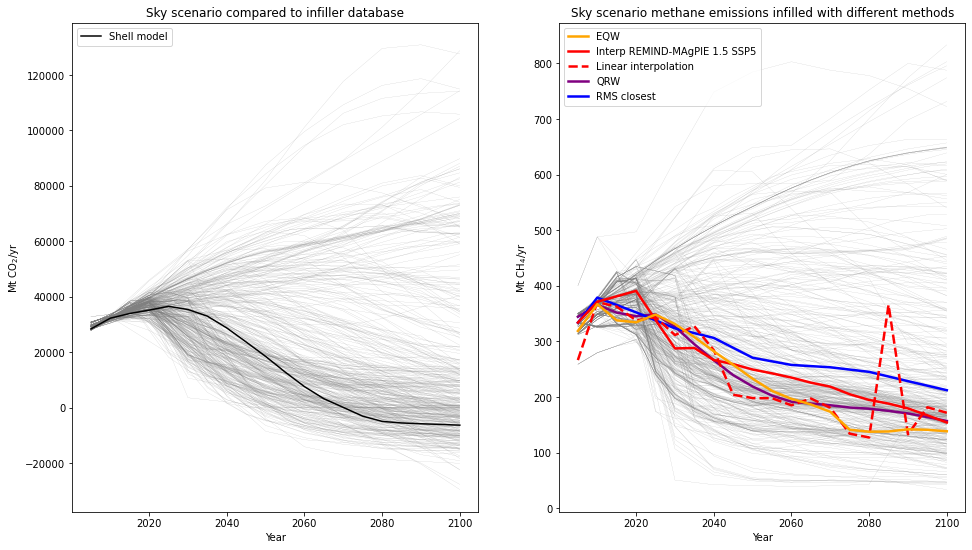

In [15]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
df.filter(variable=lead, year=df_to_infill.data["year"].unique()).line_plot(
    ax=ax, linewidth=0.1, label='_nolegend_', color="grey"
)
df_to_infill.filter(variable=lead).line_plot(ax=ax, color="black", label="Shell model")
ax.set_title("Sky scenario compared to infiller database")
ax.set_ylabel("Mt CO$_2$/yr")
ax = fig.add_subplot(122)
df.filter(variable="Emissions|CH4", year=df_to_infill.data["year"].unique()).line_plot(
    ax=ax, linewidth=0.1, label='_nolegend_', color="grey"
)
quantile_infilled.filter(variable="Emissions|CH4").line_plot(
    ax=ax, linewidth=2.5, color="purple", label="QRW"
)
closest_infilled.filter(variable="Emissions|CH4").line_plot(
    ax=ax, color="blue", linewidth=2.5, label="RMS closest"
)
interp_spec_infilled.filter(variable="Emissions|CH4").line_plot(
    ax=ax, color="red", linewidth=2.5, label="Interp REMIND-MAgPIE 1.5 SSP5"
)
interp_infilled.filter(variable="Emissions|CH4").line_plot(
    ax=ax, color="red", linewidth=2.5, label="Linear interpolation", linestyle="--"
)
EQW_infilled.filter(variable="Emissions|CH4").line_plot(
    ax=ax, color="orange", linewidth=2.5, label="EQW"
)
ax.set_ylabel("Mt CH$_4$/yr")
ax.set_title("Sky scenario methane emissions infilled with different methods")

In [16]:
quantile_infilled["scenario"] = "QRW"
closest_infilled["scenario"] = "RMS closest"
interp_spec_infilled["scenario"] = "Interp REMIND-MAgPIE 1.5 SSP5"
interp_spec_infilled_complete["scenario"] = "Interp AIM/GCE 2.1 Transport"
EQW_infilled["scenario"] = "EQW"

all_results = pd.concat(
    [
        quantile_infilled.data, closest_infilled.data,
        interp_spec_infilled_complete.data, EQW_infilled.data
    ]
)

In [17]:
pyam.IamDataFrame(all_results).to_csv("../output/SkyScenarioMoreComplete.csv")